In [ ]:
#| echo: false
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from collections import defaultdict

<br>
<iframe src="https://slc99-quote-machine.hf.space" width="100%" height="800" style="box-shadow: 0 2px 8px var(--bs-body-color);"></iframe>

## Recruiter TLDR
**End-to-end NLP project** that predicts author metadata from text.

- **Data Engineering**: Built a custom scraper for Wikiquote & Wikimedia to curate a high-quality dataset of quotes mapped to author metadata (birth year, occupation, gender).
- **Modeling**: Fine-tuned a Transformer-based architecture (Sentence-BERT backbone + Custom PyTorch heads) for multi-task learning: simultaneous regression (birth year) and classification (occupation).
- **Deployment**: Deployed a scalable inference API and interactive UI via Hugging Face Spaces & Gradio, featuring vector-based semantic search using FAISS.


## Introduction
- **Goal**: Create a deep learning model that can predict author characteristics from their quotes. This can help identify misattributed quotes.
- **Data**: Quote data was scraped from [Wikiquote](https://en.wikiquote.org/wiki/Main_Page) and author attributes were pulled from [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page). After cleaning and filtering, the dataset contained 233k quotes from 11k authors. Author occupations were mapped into 19 categories, while author birth year was converted to a scaled target value.
- **Model**
    - *Model architecture*: The model architecture contains three components: a pretrained encoder model, shared linear layers, and author-attribute prediction MLP heads.
    - *Model training*: The model was trained on a cloud-based GPU instance ([Runpod](https://www.runpod.io/)). Metrics were tracked using [Weights & Biases](https://wandb.ai/).
    - *Model hosting*: The model is presented with Gradio and hosted on a Hugging Face Space. Quote similarity, as measured by L2 distance, is calculated with FAISS (Facebook AI Similarity Search).

## Data
### Data Scraping
Quotes were scraped from [Wikiquote](https://en.wikiquote.org/wiki/Main_Page). Wikiquote was selected over the popular [Goodreads](https://www.kaggle.com/datasets/akmittal/quotes-dataset) dataset for two reasons: first, Wikiquote provides a Wikimedia ID, allowing accurate author-attribute matching; second, Goodreads has many misattributed quotes, which runs counter to the original motivation.

I used [BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/) to scrape Wikiquote. I first collected individual profile links by iterating through an index of people by name. Then, I scraped text from the *edit* page instead of the primary page because the edit page was more easily parsable. The code for the scraping is below.

In [ ]:
#| code-summary: "Wikiquote scraping code"

# ==============================
# First collect all page links
# ==============================

BASE_URL = "https://en.wikiquote.org"
START_URL = f"{BASE_URL}/wiki/List_of_people_by_name"
EDIT_URL_TEMPLATE = "https://en.wikiquote.org/w/index.php?title={}&action=edit"
PEOPLE_LINK_PATH = Path("data/scraped_data/people_edit_links.txt")


def get_people_links(url):
    """Extracts and returns (name, title) pairs from a Wikiquote page.
    Title is the formatted page name.
    """
    headers = {}  # Write header here
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")
    people_links = set()

    content_div = soup.find("div", {"id": "mw-content-text"})

    if not content_div:
        print(f"No content found in {url}")
        return people_links

    for a_tag in content_div.find_all("a", href=True):
        href = a_tag["href"]
        if href.startswith("/wiki/") and not any(
            prefix in href for prefix in [":", "#"]
        ):
            title = href.split("/wiki/")[1]
            name = a_tag.get_text(strip=True)
            people_links.add((name, title))  # store as tuple (name, title)

    return people_links


def collect_wikiquotes_edit_links():
    print(f"Collecting links from {START_URL}...")
    people_pairs = get_people_links(START_URL)

    additional_pairs = set()
    final_pairs = set()

    for name, title in list(people_pairs):
        if "List_of_people_by_name" in title:
            # Handle index pages: Add their links to the queue for further processing
            link = urljoin(BASE_URL, "/wiki/" + title)
            print(f"Checking additional page: {link}")
            time.sleep(1)
            more_pairs = get_people_links(link)
            additional_pairs.update(more_pairs)
        else:
            # Handle individual pages: Add them to the final output
            final_pairs.add((name, title))

    # Combine all links from additional pages, excluding index pages
    for name, title in additional_pairs:
        if "List_of_people_by_name" not in title:
            final_pairs.add((name, title))

    edit_urls = []
    with open(PEOPLE_LINK_PATH, "w", encoding="utf-8") as f:
        for name, title in sorted(final_pairs, key=lambda x: x[0]):  # sort by name
            edit_url = EDIT_URL_TEMPLATE.format(title)
            edit_urls.append(edit_url)
            f.write(f"{name}\t{edit_url}\n")  # write name and edit URL separated by tab

    print(f"Collected {len(edit_urls)} unique edit URLs.")


# Read the file and parse it into a list of tuples
# PEOPLE_LINK_PATH = "data\\scraped_data\\people_edit_links.txt"
if os.path.exists(PEOPLE_LINK_PATH):
    pass
else:
    collect_wikiquotes_edit_links()


with open(PEOPLE_LINK_PATH, "r", encoding="utf-8") as file:
    people_edit_links = [tuple(line.strip().split("\t")) for line in file]
names = [x[0] for x in people_edit_links]
urls = [x[1] for x in people_edit_links]


# ==============================
# Now, parse each edit page
# ==============================


def query_wikiquote(url: str) -> BeautifulSoup | None:
    """Takes an edit-page URL and returns a BeautifulSoup object."""
    # parse and extract quotes
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
    except Exception:
        print(f"Failed to fetch the page (likely timeout): {url}")
        return None

    if response.status_code != 200:
        print("Failed to fetch the page.")
        return None

    soup = BeautifulSoup(response.text, "html.parser")

    return soup


def extract_textarea(soup: BeautifulSoup) -> str:
    """Extracts the textarea content from the BeautifulSoup object."""
    textarea = soup.find("textarea", {"name": "wpTextbox1"})

    if not textarea:
        print("Couldn't find the textarea.")
        return ""

    return textarea.text


def extract_wikimedia_id(soup: BeautifulSoup) -> str:
    """Extracts the Wikimedia ID from the soup object."""
    # Find the <a> tag with the desired href
    link = soup.find("a", class_="extiw wb-entity-link external")
    # Extract the Q-number from the href attribute
    q_number = ""
    if link and "href" in link.attrs:
        href = link["href"]
        q_number = href.split("/")[-1]  # Extract the last part of the URL
    return q_number


output_csv = Path("data/scraped_data/wikiquotes_scraped.csv")
seen_names = set()

# This loop was necessary to resume scraping after interruptions
while len(seen_names) + 50 < len(names):
    # Check if the file exists to determine whether to write the header
    file_exists = os.path.isfile(output_csv)

    if file_exists:
        scraped_data = pd.read_csv(output_csv, encoding="utf-8")
        seen_names.update(scraped_data["name"].tolist())

    with open(output_csv, "a", newline="", encoding="utf-8") as csvfile:
        fieldnames = ["name", "wikimedia_id", "raw_text"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quoting=csv.QUOTE_ALL)
        if not file_exists:
            writer.writeheader()

        for name, url in zip(names, urls):
            if name in seen_names:
                print(f"Skipping {name} as it has already been processed.")
                continue
            print(f"Processing {name} from {url}...")
            if not url.startswith("https://en.wikiquote.org/w/index.php?title="):
                print(f"Skipping {name} as the URL is not an edit page.")
                continue
            soup = query_wikiquote(url)
            if soup is None:
                print(f"Skipping {name} due to query failure.")
                continue
            wikimedia_id = extract_wikimedia_id(soup)
            raw_text = extract_textarea(soup)
            writer.writerow(
                {"name": name, "wikimedia_id": wikimedia_id, "raw_text": raw_text},
            )
            time.sleep(0.5)

results_df = pd.read_csv(output_csv, encoding="utf-8")
wikimedia_ids = set(results_df["wikimedia_id"].tolist())

wikimedia_id_path = Path("data/scraped_data/wikimedia_ids.txt")
with open(wikimedia_id_path, "w", encoding="utf-8") as f:
    for wikimedia_id in wikimedia_ids:
        f.write(f"{wikimedia_id}\n")


I accessed [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page) through their API. I retrieved data on each author's birth year, death year, occupation, nationality, gender, and average monthly page views.

### Data Cleaning

Owing to the crowdsourced nature of Wikiquote, the initial data pull was *very* messy. I performed the following processing steps:

1. Parse individual quotes and their associated headers from the full edit text. Recording the header was necessary because many pages include a "Misattributed" or "Quotes About [Person]" section that should be filtered.
2. Mark bolded quote segments. Many Wikiquote entries include a memorable bolded quote alongside significant context. I recorded and marked the bolded fragments for later processing.
3. Clean common markup artifacts.
4. Filter non-English quotes.
5. Perform systematic checks and spot checks to remove other abnormalities from the scraped data, such as external links, specific poorly formatted authors, and quotes with messy headers.

Cleaning the author data was much simpler.

In [ ]:
#| code-summary: "Quote data cleaning"
def text_to_list(text: str) -> list[str]:
    """
    Parse markdown text into a list of section headers and quotes.
    Finds all strings that begin with "=" (section headers) or "*" (quotes).
    """
    return re.findall(r"^[=*].*$", text, re.MULTILINE)


def quotes_from_list(section_headers_and_quotes: list[str]) -> list[dict]:
    """
    Extract quotes with their associated metadata from parsed text.
    Processes a list of headers and quotes, organizing them into dictionaries
    with header, subheader, and notes information.
    """
    header = ""
    subheader = ""
    recorded_quotes: list[dict] = []
    for dirty in section_headers_and_quotes:
        # Headers
        if re.match(r"^==[^=].*[^=]==$", dirty):
            header = dirty.strip("= ")
        # Subheaders
        elif re.match(r"^===[^=].*[^=]===$", dirty):
            subheader = dirty.strip("= ")
        # Quotes
        elif re.match(r"^\*\*[^*]", dirty):
            if recorded_quotes:
                recorded_quotes[-1]["notes"].append(dirty.strip("* "))
        elif re.match(r"^\*[^*]", dirty):
            quote_dict = {
                "raw_quote": dirty.strip("* "),
                "header": header,
                "subheader": subheader,
                "notes": [],
            }
            recorded_quotes.append(quote_dict)
    return recorded_quotes


def join_fragments(fragments: list[str], original_text: str) -> str:
    """
    Join bolded quote fragments with appropriate separators.
    Combines multiple bolded subsections into a single quote, using different
    separators based on whether fragments are part of the same sentence.
    """
    result = []
    last_end = 0

    for i, fragment in enumerate(fragments):
        if i > 0:
            # Find the text between the last bold fragment and the current one
            start = original_text.find(f"'''{fragment}'''", last_end)
            in_between_text = original_text[last_end:start]
            last_end = start + len(f"'''{fragment}'''")

            # Check if the in-between text contains a sentence-ending punctuation
            if re.search(r"[.!?]", in_between_text) and not re.search(
                r"[.!?]$", result[-1]
            ):
                result.append(" .... ")  # Different sentence
            else:
                result.append(" ... ")  # Same sentence

        result.append(fragment)
    return "".join(result)


def parse_to_bold(q_dict: dict) -> list[dict]:
    """
    Extract and mark bolded quote sections.
    Creates separate entries for complete quotes and their bolded fragments,
    with flags indicating whether text is bolded.
    """

    def fill_dict(
        quote_to_add: str, orig_dict: dict, bold_fragment: bool, bold_combined: bool
    ) -> dict:
        """Helper function to create quote dictionary with bold metadata."""
        bold = bold_fragment or bold_combined
        quote_dict = {
            "raw_quote": quote_to_add,
            "raw_complete_quote": orig_dict["raw_quote"],
            "bold": bold,
            "bold_fragment": bold_fragment,
            "bold_combined": bold_combined,
            "header": q_dict["header"],
            "subheader": q_dict["subheader"],
            "notes": q_dict["notes"],
        }
        return quote_dict

    recorded_with_bold: list[dict] = []
    quote = q_dict["raw_quote"]
    quote_dict = fill_dict(quote, q_dict, False, False)
    recorded_with_bold.append(quote_dict)
    bold_fragments = re.findall(r"'''(.*?)'''", quote)

    # If there are multiple bold sections, add them separately and combined
    if len(bold_fragments) > 1:
        # Add the combined quote
        combined_fragments = join_fragments(bold_fragments, quote)
        quote_dict = fill_dict(combined_fragments, q_dict, False, True)
        recorded_with_bold.append(quote_dict)
        for bold_fragment in bold_fragments:
            # Add each fragment independently
            quote_dict = fill_dict(bold_fragment, q_dict, True, False)
            recorded_with_bold.append(quote_dict)

    # Add single bolded section
    elif len(bold_fragments) == 1:
        quote_dict = fill_dict(bold_fragments[0], q_dict, True, True)
        recorded_with_bold.append(quote_dict)

    return recorded_with_bold


def cleaner(dirty: str) -> str:
    """
    Remove common markup formatting from text.
    Strips wiki markup, HTML tags, special characters, and extra whitespace
    while preserving basic punctuation and readability.
    """
    dirty = (
        dirty.replace("'''", "")
        .replace("''", "")
        .strip("*")
        .lstrip()
        .replace("[[w:", "")
    )
    dirty = re.sub(r"<br>", " ", dirty)
    dirty = re.sub(r"{{.*?}}", "", dirty)
    dirty = re.sub(r"</?[^>]+>", "", dirty)
    dirty = re.sub(r"\|.*?\]\]", "", dirty)
    dirty = re.sub(
        r"[^0-9A-Za-z\s\.,\?!:;\'\"\(\)\-\u2013\u2014\/\u2018\u2019\u201c\u201d\u2026&]",
        "",
        dirty,
    )
    clean = re.sub(r"\s+", " ", dirty).strip()
    return clean


def clean_bold_dict(input_dict: dict) -> dict:
    """
    Apply cleaner function to all text fields in quote dictionary.
    """
    q_dict = input_dict.copy()

    q_dict["header"] = cleaner(q_dict["header"])
    q_dict["subheader"] = cleaner(q_dict["subheader"])
    cleaned_notes = []
    for note in q_dict["notes"]:
        cleaned_notes.append(cleaner(note))
    q_dict["notes"] = cleaned_notes

    if not q_dict["raw_quote"]:
        return q_dict
    q_dict["clean_quote"] = cleaner(q_dict["raw_quote"])
    q_dict["clean_complete_quote"] = cleaner(q_dict["raw_complete_quote"])

    return q_dict


def page_pipeline(text: str) -> list[dict]:
    """
    Complete processing pipeline for a Wikiquote page.
    Parses raw edit page text through all cleaning and processing steps
    to extract structured quote data.
    """
    section_headers_and_quotes: list[str] = text_to_list(text)
    quote_dicts: list[dict] = quotes_from_list(section_headers_and_quotes)
    cleaned_bold_dicts: list[dict] = []
    for q_dict in quote_dicts:
        bold_dicts: list[dict] = parse_to_bold(q_dict)
        for bold in bold_dicts:
            cleaned_bold: dict = clean_bold_dict(bold)
            cleaned_bold_dicts.append(cleaned_bold)
    return cleaned_bold_dicts


# Read raw scraped data
csv_path = os.path.join("data", "scraped_data", "wikiquotes_scraped.csv")
raw_quotes = pd.read_csv(csv_path)

# Apply the pipeline and explode the results into a new DataFrame
processed = raw_quotes.apply(
    lambda row: [
        {**elem, "wikimedia_id": row["wikimedia_id"], "name": row["name"]}
        for elem in page_pipeline(row["raw_text"])
    ],
    axis=1,
)

# Flatten the list of lists and create a DataFrame
flat_list = [item for sublist in processed for item in sublist]
quotes_df = pd.DataFrame(flat_list)


def filter_about(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter out quotes about people rather than by them.
    Removes sections containing quotes discussing a person rather than
    quotes spoken or written by that person.
    """
    about_filter = r"^\s*(Quotations regarding Spinoza|Song lyrics about Lars Ulrich|Film directors about|Some more interesting facts about Mukesh Ambani|Comments About|Quotes from stars|quotes about|quotations about|about|quotes of others|quotations of others|quotes from others|quotes by others|quotation about|said about)"
    return df[~df["header"].str.contains(about_filter, case=False, na=False)]


def filter_external_links(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove external links and 'See also' sections.
    """
    df = df[df["header"] != "External links"]
    df = df[df["header"] != "See also"]
    return df


def filter_works(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove pages that contain works instead of quotes.
    Filters out entries where the content is primarily a list of works
    rather than actual quotations, with specific exceptions.
    """
    df = df[
        ~df["header"].str.contains("work", case=False, na=False)
        | ~df["name"].isin(
            [
                "Malek, Marcin",
                "Kok, Ingrid de",
                "Maharaj, Nisargadatta",
                "Rice, Tim",
                "Waberi, Abdourahman",
            ]
        )
    ]
    return df


def filter_fragments(
    df: pd.DataFrame, full_cutoff: int = 3, bold_cutoof: int = 5
) -> pd.DataFrame:
    """
    Remove quote fragments that are too short.
    Filters quotes with fewer than 3 words, or fewer than 5 words for
    bold fragments which tend to be shorter memorable phrases.
    """
    df = df[
        ~(
            (df["clean_quote"].str.split().str.len() < full_cutoff)
            | (
                (df["bold_fragment"] == True)
                & (df["clean_quote"].str.split().str.len() < bold_cutoof)
            )
        )
    ]
    return df


def filter_starting_numbers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove leading numbers and periods from quotes.
    """
    df["clean_quote"] = df["clean_quote"].str.replace(r"^\d+\.\s*", "", regex=True)
    return df


def filter_non_string(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove entries where clean_quote is not a string.
    """
    return df[df["clean_quote"].apply(lambda x: isinstance(x, str))]


def add_misattributed_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add boolean column indicating misattributed or disputed quotes.
    Marks quotes from 'Misattributed' or 'Disputed' sections.
    """
    df["misattributed"] = df["header"].isin(["Misattributed", "Disputed"]) | (
        df["subheader"] == "Misattributed"
    )
    return df


def add_is_en_col(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add boolean column indicating whether quote is in English.
    Uses langdetect library to identify English quotes.
    """

    def detect_language(text):
        """Detect if text is English, handling exceptions."""
        if isinstance(text, float):
            return False
        try:
            return detect(text) == "en"
        except LangDetectException:
            return False

    amended = df.copy(deep=True)
    amended["is_en"] = amended["clean_quote"].progress_apply(detect_language)

    return amended


def filter_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply all filtering and processing steps to quote DataFrame.
    Runs the complete sequence of filters to produce a clean dataset
    ready for model training.
    """
    df = filter_about(df)
    df = filter_external_links(df)
    df = filter_works(df)
    df = filter_fragments(df)
    df = filter_starting_numbers(df)
    df = filter_non_string(df)
    df = add_misattributed_column(df)
    df = add_is_en_col(df)
    return df


quotes_df = filter_pipeline(quotes_df)

In [ ]:
#| code-summary: "Author data cleaning"


def split_lowercase_list(df: pd.DataFrame, column: str) -> pd.DataFrame:
    df[column] = df[column].apply(
        lambda x: [item.strip().lower() for item in x.split(",")] if pd.notna(x) else x
    )
    return df


def replace_empty_list_with_null(df: pd.DataFrame, column: str) -> pd.DataFrame:
    df = df.copy()
    df[column] = df[column].apply(
        lambda x: np.nan if isinstance(x, list) and not x else x
    )
    return df


def limit_by_frequency(
    df: pd.DataFrame, column: str, min_freq: int, suffix: str = "_limited"
) -> pd.DataFrame:
    """Creates a new column that only includes values with at least `min_freq` occurrences."""
    df = df.copy()
    val_counts = pd.Series([x for y in df[column].dropna() for x in y]).value_counts()
    vals_above_min = val_counts[val_counts >= min_freq].index.tolist()
    df[column + suffix] = df[column].apply(
        lambda lst: (
            [val for val in lst if val in vals_above_min]
            if isinstance(lst, list)
            else lst
        )
    )
    return df


def limit_by_top_k(
    df: pd.DataFrame, column: str, k: int, suffix: str = "_limited"
) -> pd.DataFrame:
    """Creates a new column that only includes values in the list of the top-k most frequent values."""
    df = df.copy()
    val_counts = pd.Series([x for y in df[column].dropna() for x in y]).value_counts()
    top_k_vals = val_counts.head(k).index.tolist()
    df[column + suffix] = df[column].apply(
        lambda lst: (
            [val for val in lst if val in top_k_vals] if isinstance(lst, list) else lst
        )
    )
    return df


def replace_val(
    df: pd.DataFrame, column: str, val, replace_with: float = np.nan
) -> pd.DataFrame:
    df = df.copy()
    df[column].replace(val, replace_with)
    return df


def create_limited_dummies(
    df: pd.DataFrame, column: str, vals: list, suffix: str = "_dummy"
) -> pd.DataFrame:
    df = df.copy()
    for val in vals:
        df[column + suffix + "_" + val] = (df[column] == val).astype(int)
    df.loc[df[column].isna()] = np.nan
    return df


def fill_na(df: pd.DataFrame, column: str, func=pd.Series.median) -> pd.DataFrame:
    df = df.copy()
    fill_value = func(df[column])
    df[column] = df[column].fillna(fill_value)
    return df


def add_log(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        df[f"log_{col}"] = np.log(df[col])

    return df


def mapping(
    df: pd.DataFrame,
    column_name: str,
    map_dict: dict[str, str],
    rsuffix: str = "_mapped",
) -> pd.DataFrame:

    return df.join(df[column_name].map(map_dict), rsuffix=rsuffix)


authors = pd.read_csv(os.path.join("data", "scraped_data", "wikimedia_details.csv"))
authors = (
    authors.pipe(split_lowercase_list, column="occupation")
    .pipe(replace_empty_list_with_null, column="occupation")
    .pipe(limit_by_top_k, column="occupation", k=50)
    .pipe(replace_val, column="avg_monthly_pageviews", val=0.0, replace_with=1e-8)
    .pipe(create_limited_dummies, column="gender", vals=["male", "female"])
    .pipe(add_log, columns=["avg_monthly_pageviews"])
)


### Data Processing for Training

Now that I had clean(er) data, it was time to prepare the data for model training. I performed the following steps:

1. *Create a multi-label target for occupation*: Due to Wikidata being crowdsourced, the author data contained hundreds of obscure occupations. To create reasonable targets, I filtered to the 200 most common occupations (dropping 290 of 11,761 authors) and then had <`an LLM`> categorize occupations. I then manually tweaked categories. I selected this approach over an occupation co-occurrence clustering approach, as the manual method produced more semantically meaningful categories.
2. *Create category weights to address occupation skew*: The most popular category, `Literature & Writing`, has 100x as many samples as the least popular category, `Athletes & Sports`. To address this, I added a scaling factor for occupation categories, defined as $\text{w}_i = \frac{\max w}{\text{count}^\alpha}$, where $\alpha \in [0, 1]$ is a scaling hyperparameter. These weights were used to scale loss during backpropagation. A full breakdown of categories, associated quote counts, and weights is provided below.

In [ ]:
#| code-summary: "Occupation mapping"

occupation_mapping = {
    "writer": "Literature & Writing",
    "poet": "Literature & Writing",
    "novelist": "Literature & Writing",
    "essayist": "Literature & Writing",
    "children's writer": "Literature & Writing",
    "short story writer": "Literature & Writing",
    "prose writer": "Literature & Writing",
    "diarist": "Literature & Writing",
    "science fiction writer": "Literature & Writing",
    "librettist": "Literature & Writing",
    "author": "Literature & Writing",
    "literary scholar": "Literature & Writing",
    "humorist": "Literature & Writing",
    "journalist": "Journalism & Media",
    "editor": "Journalism & Media",
    "columnist": "Journalism & Media",
    "blogger": "Journalism & Media",
    "opinion journalist": "Journalism & Media",
    "television presenter": "Journalism & Media",
    "radio personality": "Journalism & Media",
    "podcaster": "Journalism & Media",
    "pundit": "Journalism & Media",
    "publisher": "Journalism & Media",
    "editing staff": "Journalism & Media",
    "painter": "Visual Arts & Design",
    "sculptor": "Visual Arts & Design",
    "photographer": "Visual Arts & Design",
    "illustrator": "Visual Arts & Design",
    "draftsperson": "Visual Arts & Design",
    "visual artist": "Visual Arts & Design",
    "printmaker": "Visual Arts & Design",
    "graphic artist": "Visual Arts & Design",
    "designer": "Visual Arts & Design",
    "architect": "Visual Arts & Design",
    "architectural draftsperson": "Visual Arts & Design",
    "fashion designer": "Visual Arts & Design",
    "lithographer": "Visual Arts & Design",
    "cartoonist": "Visual Arts & Design",
    "comics artist": "Visual Arts & Design",
    "artist": "Visual Arts & Design",
    "singer": "Music",
    "composer": "Music",
    "songwriter": "Music",
    "singer-songwriter": "Music",
    "musician": "Music",
    "guitarist": "Music",
    "pianist": "Music",
    "record producer": "Music",
    "recording artist": "Music",
    "lyricist": "Music",
    "conductor": "Music",
    "rapper": "Music",
    "jazz musician": "Music",
    "organist": "Music",
    "disc jockey": "Music",
    "violinist": "Music",
    "film score composer": "Music",
    "actor": "Actor",
    "film actor": "Actor",
    "television actor": "Actor",
    "stage actor": "Actor",
    "voice actor": "Actor",
    "screenwriter": "Film & Theater Writer",
    "playwright": "Film & Theater Writer",
    "film director": "Film, TV, & Theater Production",
    "film producer": "Film, TV, & Theater Production",
    "television producer": "Film, TV, & Theater Production",
    "television director": "Film, TV, & Theater Production",
    "theatrical director": "Film, TV, & Theater Production",
    "film editor": "Film, TV, & Theater Production",
    "executive producer": "Film, TV, & Theater Production",
    "choreographer": "Film, TV, & Theater Production",
    "dramaturge": "Film, TV, & Theater Production",
    "director": "Film, TV, & Theater Production",
    "producer": "Film, TV, & Theater Production",
    "physicist": "Science & Math",
    "theoretical physicist": "Science & Math",
    "nuclear physicist": "Science & Math",
    "astrophysicist": "Science & Math",
    "chemist": "Science & Math",
    "biologist": "Science & Math",
    "biochemist": "Science & Math",
    "zoologist": "Science & Math",
    "botanist": "Science & Math",
    "geneticist": "Science & Math",
    "geologist": "Science & Math",
    "astronomer": "Science & Math",
    "naturalist": "Science & Math",
    "mathematician": "Science & Math",
    "statistician": "Science & Math",
    "philosopher": "Humanities",
    "historian": "Humanities",
    "theologian": "Humanities",
    "linguist": "Humanities",
    "classical scholar": "Humanities",
    "art historian": "Humanities",
    "archaeologist": "Humanities",
    "economist": "Social Sciences",
    "sociologist": "Social Sciences",
    "psychologist": "Social Sciences",
    "political scientist": "Social Sciences",
    "anthropologist": "Social Sciences",
    "geographer": "Social Sciences",
    "sociologist": "Social Sciences",
    "music theorist": "Music",
    "university teacher": "Academia & Education",
    "teacher": "Academia & Education",
    "professor": "Academia & Education",
    "pedagogue": "Academia & Education",
    "lecturer": "Academia & Education",
    "academic": "Academia & Education",
    "researcher": "Academia & Education",
    "music educator": "Academia & Education",
    "librarian": "Academia & Education",
    "educator": "Academia & Education",
    "lawyer": "Law & Jurisprudence",
    "judge": "Law & Jurisprudence",
    "jurist": "Law & Jurisprudence",
    "barrister": "Law & Jurisprudence",
    "poet lawyer": "Law & Jurisprudence",
    "politician": "Politics & Government",
    "diplomat": "Politics & Government",
    "statesperson": "Politics & Government",
    "monarch": "Politics & Government",
    "civil servant": "Politics & Government",
    "theologian": "Religion",
    "catholic priest": "Religion",
    "anglican priest": "Religion",
    "rabbi": "Religion",
    "pastor": "Religion",
    "missionary": "Religion",
    "preacher": "Religion",
    "religious leader": "Religion",
    "catholic bishop": "Religion",
    "minister": "Religion",
    "christian minister": "Religion",
    "cleric": "Religion",
    "priest": "Religion",
    "businessperson": "Business & Finance",
    "entrepreneur": "Business & Finance",
    "banker": "Business & Finance",
    "merchant": "Business & Finance",
    "manufacturer": "Business & Finance",
    "engineer": "Technology",
    "computer scientist": "Technology",
    "programmer": "Technology",
    "inventor": "Technology",
    "activist": "Social Advocacy",
    "human rights defender": "Social Advocacy",
    "trade unionist": "Social Advocacy",
    "peace activist": "Social Advocacy",
    "political activist": "Social Advocacy",
    "women's rights activist": "Social Advocacy",
    "environmentalist": "Social Advocacy",
    "revolutionary": "Politics & Government",
    "abolitionist": "Social Advocacy",
    "military personnel": "Military",
    "military officer": "Military",
    "naval officer": "Military",
    "army officer": "Military",
    "military leader": "Military",
    "soldier": "Military",
    "association football player": "Athletes & Sports",
    "american football player": "Athletes & Sports",
    "basketball player": "Athletes & Sports",
    "cricketer": "Athletes & Sports",
    "boxer": "Athletes & Sports",
    "dancer": "Athletes & Sports",
    "baseball player": "Athletes & Sports",
    "association football coach": "Athletes & Sports",
    "literary critic": "Literature & Writing",
    "non-fiction writer": "Literature & Writing",
    "scientist": "Science & Math",
}

In [ ]:
#| code-summary: "Categories, quote counts, weights"

counts = defaultdict(int)
total_counted = 0

for authors_occupations in df["occupation"].dropna():
    quote_counted = 0
    seen_categories = set()
    for occupation in authors_occupations:
        category = occupation_mapping.get(occupation)
        if category and category not in seen_categories:
            counts[category] += 1
            quote_counted = 1
            seen_categories.add(category)
    total_counted += quote_counted

for (occupation, count), weight in zip(
    sorted(counts.items(), key=lambda x: x[1], reverse=True),
    sorted(occupation_weights, reverse=False),
):
    print(
        f"{occupation:<30}: {count / sum(counts.values()):>6.1%}. {weight:>5.1f} weight, {count:>7,.0f} quotes"
    )
"""
Literature & Writing          :  23.7%.   1.0 weight, 174,633 quotes
Politics & Government         :   8.8%.   1.6 weight,  65,293 quotes
Journalism & Media            :   8.8%.   1.6 weight,  64,734 quotes
Humanities                    :   8.4%.   1.7 weight,  62,323 quotes
Academia & Education          :   7.9%.   1.7 weight,  58,063 quotes
Film & Theater Writer         :   7.1%.   1.8 weight,  52,273 quotes
Actor                         :   3.9%.   2.5 weight,  28,533 quotes
Music                         :   3.8%.   2.5 weight,  28,148 quotes
Social Sciences               :   3.7%.   2.5 weight,  26,948 quotes
Film, TV, & Theater Production:   3.4%.   2.6 weight,  25,393 quotes
Science & Math                :   3.4%.   2.6 weight,  25,018 quotes
Law & Jurisprudence           :   3.2%.   2.7 weight,  23,372 quotes
Visual Arts & Design          :   3.0%.   2.8 weight,  22,269 quotes
Social Advocacy               :   2.6%.   3.0 weight,  19,126 quotes
Religion                      :   2.3%.   3.2 weight,  17,316 quotes
Military                      :   2.0%.   3.4 weight,  14,946 quotes
Business & Finance            :   1.8%.   3.7 weight,  12,984 quotes
Technology                    :   1.5%.   3.9 weight,  11,341 quotes
Athletes & Sports             :   0.7%.   5.8 weight,   5,169 quotes
"""

3. *Create birth year targets*: Ideally, the model would predict when a quote was said. I use the author's birth year as a proxy, given the available data. I wanted the birth year target to meet the following constraints:
    1. Penalize the same absolute error more when the year is closer to the present day, so that predicting 200 CE for 400 CE is minor, but predicting 1800 CE for 2000 CE is major.
    2. Predict a value with a continuous domain, to enable encoding the continuous development of language. This ruled out binarized approaches.
    
To achieve these goals, I defined $\text{Year label}= \log (b-x) - \log(b-c)$, where $c = 2025$ (the current year) is used to set the intercept, and $b$ is a hyperparameter that determines the steepness of the slope, which captures the relative weight of date differences in the present day vs. the far past. I $z$-normalized the converted target.
4. *Weight quotes by author's popularity and number of quotes*: There were two problems with the current data. First, the number of quotes per author varies by orders of magnitude. Second, I wanted "higher quality" authors (as measured by Wikipedia page views) to be upsampled. To achieve this, we set $w_{\text{quote}} = \frac{\log_2(\text{author page views})}{\text{total author quotes}}$. Authors with missing page view counts were assumed to be missing uniformly at random.

In [ ]:
#| code-summary: "Birth year target"

authors["birth_year_target"] = authors["birth_year"].apply(
    lambda x: np.log((2050 - x)) - np.log((2050 - 2025)) if pd.notnull(x) else np.nan
)
scaler_fn = StandardScaler()
authors["birth_year_target"] = scaler_fn.fit_transform(authors[["birth_year_target"]])

df = pd.merge(
    quotes, authors, left_on="wikimedia_id", right_on="wikidata_id", how="left"
)

base = 2
df[f"log_{base}_views"] = df["avg_monthly_pageviews"].apply(
    lambda x: np.log(x) / np.log(base) if pd.notnull(x) else 1
)
df["num_quotes"] = df.groupby("wikimedia_id")["wikimedia_id"].transform("count")
df["weight"] = df["log_2_views"] / df["num_quotes"]

## Model 
### Model Design 
The model uses a pretrained sentence-embedding model as a backbone. I selected the [Sentence Transformers](https://sbert.net/) model [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) because it is lightweight and popular. Encoded quotes are then passed through a set of shared add-on layers, composed of linear, ReLU, and dropout layers. The depth and width of these layers were parameterized. The last shared layer feeds into three prediction heads for gender, year, and occupation.

In [ ]:
#| code-summary: "PyTorch model class"


class AuthorPredictor(nn.Module):
    def __init__(
        self,
        encoder,
        occupation_classes,
        device,
        add_on_layer_dims: list[int] | None = [128],
        dropout_p: float = 0.1,
        return_embeddings: bool = False,
        extra_occupations_layer: bool = True,
        use_hetrosk_year_loss: bool = False,
    ):
        super(AuthorPredictor, self).__init__()
        self.encoder = encoder
        self.device = device
        self.dropout = nn.Dropout(dropout_p)
        self.return_embeddings = return_embeddings
        self.add_on_layer_dims = add_on_layer_dims
        self.use_hetrosk_year_loss = use_hetrosk_year_loss
        self.occupation_classes = occupation_classes

        encoded_dim = encoder.config.hidden_size

        if add_on_layer_dims:
            layers = []
            in_dim = encoded_dim
            for out_dim in add_on_layer_dims:
                layers.extend(
                    [
                        nn.Linear(in_dim, out_dim),
                        nn.ReLU(),
                        nn.Dropout(dropout_p),
                    ]
                )
                in_dim = out_dim

            self.add_on_layers = nn.Sequential(*layers)

        latent_dim = add_on_layer_dims[-1] if add_on_layer_dims else encoded_dim

        # Prediction heads
        if extra_occupations_layer:
            self.occupation_head = nn.Sequential(
                nn.Linear(latent_dim, latent_dim),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(latent_dim, occupation_classes),
            )
        else:
            self.occupation_head = nn.Linear(latent_dim, occupation_classes)

        year_out = 2 if use_hetrosk_year_loss else 1
        self.birth_year_head = nn.Linear(latent_dim, year_out)
        self.gender_head = nn.Linear(latent_dim, 1)

    def forward(self, tokens, attention_mask=None):
        # Convert tokens to embeddings
        embeddings = self.encoder(
            tokens, attention_mask=attention_mask
        ).last_hidden_state[:, 0, :]

        task_embeddings = self.dropout(embeddings)

        if self.add_on_layer_dims:
            task_embeddings = self.add_on_layers(task_embeddings)

        # Forward through each head
        birth_pred = self.birth_year_head(task_embeddings)
        occupation_pred = self.occupation_head(task_embeddings)

        # Detach embeddings so that noisy gender does not affect the backbone
        gender_pred = self.gender_head(task_embeddings.detach())

        # Allow embeddings to be returned
        if self.return_embeddings:
            return birth_pred, gender_pred, occupation_pred, embeddings

        return birth_pred, gender_pred, occupation_pred


### Training Parameters

<u>Loss functions </u> 

- *Gender loss*: The gender prediction head used binary cross-entropy (BCE). After empirical testing, the noisiness of the gender head was preventing the model from learning. To address this, I detached the embeddings before feeding them into the gender head, isolating gender backpropagation to the prediction head only. 
- *Occupation loss*: I tested two loss functions for the occupation head, BCE and focal loss. Loss was calculated per occupation category, scaled by the previously calculated weights, and then averaged. This prevented the model from ignoring less common occupations. 
- *Birth year loss*: Birth year loss was calculated using heteroskedastic negative log-likelihood (HNLL). As given below, HNLL requires the model to predict a normal distribution for each sample. $$ \mathcal{L}(y, \mu, \sigma^2)= \frac{1}{2}\log\!\left(2\pi\sigma^2\right) + \frac{(y - \mu)^2}{2\sigma^2}.$$
HNLL was chosen over MSE to reduce regression to the mean. HNLL also has the added benefit of including a measure of model uncertainty.

<u>Training Regime</u>

- *Phases*: The training regime was split into two phases. In the first phase, only the added layers and prediction heads are modified. In the second phase, the encoder model is also modified. 
- *Optimizer*: AdamW was selected as the optimizer. The learning rate for the encoder, add-on layers, and each prediction head are set separately.
- *Scheduling*: The learning rate was scheduled with a linear warmup (10% of total batches) and linear decay (90% of batches). Scheduling reset between phases. The second phase had a proportionally lower learning rate than the first phase.  The first phase lasted four epochs (empirically set based on when performance plateaued). The second phase lasted up to 12 epochs, depending on early stopping.
- *Evaluation*: Model performance was evaluated against a withheld validation set. The validation set contained 15% of the overall data. Model performance was calculated as the weighted average of task performance. 
    - *Gender*: AUROC
    - *Year*: MAE
    - *Occupation*: Hamming distance, with multi-label "macro" reduction. This places more emphasis on uncommon labels

In [ ]:
#| code-summary: "Training schedule and run functions"

class TrainSchedule:
    def __init__(
        self,
        model,
        epochs_last_only,
        epochs_joint,
        train_dataloader,
        val_dataloader,
        birth_year_loss_fn,
        gender_loss_fn,
        occupation_loss_fn,
        lr,
        device,
        reporting_and_early_stopping_weights: dict[str, float],
        backprop_weights: dict[str, float],
        joint_lr_multiplier,
        early_stopping_epochs: int | None,
        occupation_class_weights: torch.Tensor,
    ):
        self.model = model
        self.epochs_last_only = epochs_last_only
        self.epochs_joint = epochs_joint
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.birth_year_loss_fn = birth_year_loss_fn
        self.gender_loss_fn = gender_loss_fn
        self.occupation_loss_fn = occupation_loss_fn
        self.device = device
        self.early_stopping_epochs = early_stopping_epochs
        self.lr = lr
        self.metric_weights = reporting_and_early_stopping_weights
        self.backprop_weights = backprop_weights
        self.joint_lr_multiplier = joint_lr_multiplier
        self.occupation_class_weights = occupation_class_weights

    def epoch(self, train: bool):
        if train:
            dataloader = self.train_dataloader
            optimizer = self.optimizer
            label = "train"
            self.model.train()
        else:
            dataloader = self.val_dataloader
            optimizer = None
            label = "val"
            self.model.eval()

        dl_gender = 0.0
        dl_occupation = 0.0
        dl_year = 0.0
        dl_gender_weighted = 0.0
        dl_occupation_weighted = 0.0
        dl_year_weighted = 0.0

        # Metrics
        gender_metric = BinaryAUROC().to(device=self.device)
        year_metric = MeanAbsoluteError().to(device=self.device)
        year_std_metric = StdMetric().to(device=self.device)
        occupation_metric = MultilabelHammingDistance(
            num_labels=self.model.occupation_classes, average="macro"
        ).to(device=self.device)

        pbar = tqdm(dataloader, desc="Avg loss")

        for batch_idx, data in enumerate(pbar):
            if optimizer:
                optimizer.zero_grad()

            # Extract targets and tokens
            tokens = data["tokens"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            birth_target = data["birth_year_target"].to(self.device).unsqueeze(1)
            gender_target = data["gender_dummy_male"].to(self.device).unsqueeze(1)
            occupation_target = data["occupation_target"].to(self.device)

            # Calculate model predictions
            birth_pred, gender_pred, occupation_pred = self.model(
                tokens, attention_mask=attention_mask
            )

            # Calculate loss per prediction head
            year_loss = self.birth_year_loss_fn(birth_pred, birth_target)
            gender_loss = self.gender_loss_fn(gender_pred, gender_target)
            occupation_loss = self.occupation_loss_fn(
                occupation_pred, occupation_target
            )
            occupation_loss = occupation_loss * self.occupation_class_weights
            occupation_loss = occupation_loss.mean()

            # Weight the losses
            year_loss_weighted = year_loss * self.backprop_weights.get("year", 1.0)
            gender_loss_weighted = gender_loss * self.backprop_weights.get(
                "gender", 1.0
            )
            occupation_loss_weighted = occupation_loss * self.backprop_weights.get(
                "occupation", 1.0
            )

            # Create loss used for backprop
            loss = year_loss_weighted + gender_loss_weighted + occupation_loss_weighted

            # Backprop
            if optimizer:
                loss.backward()
                optimizer.step()
                if self.scheduler is not None:
                    self.scheduler.step()

            # Calculate reporting metrics
            if torch.no_grad():
                if self.model.use_hetrosk_year_loss:
                    birth_pred = birth_pred[:, 0].unsqueeze(dim=1)

                year_metric.update(target=birth_target, preds=birth_pred)
                year_std_metric.update(birth_pred)

                gender_metric.update(target=gender_target, preds=gender_pred)
                occupation_metric.update(
                    target=occupation_target, preds=occupation_pred
                )

            dl_gender += gender_loss.item()
            dl_occupation += occupation_loss.item()
            dl_year += year_loss.item()

            dl_gender_weighted += gender_loss_weighted.item()
            dl_occupation_weighted += occupation_loss_weighted.item()
            dl_year_weighted += year_loss_weighted.item()

            # For tqdm reporting
            pbar_dict = {
                "gender": f"{dl_gender / (batch_idx + 1):.4f}",
                "occupation": f"{dl_occupation / (batch_idx + 1):.4f}",
                "year": f"{dl_year / (batch_idx + 1):.4f}",
            }
            pbar.set_postfix(pbar_dict)

        # End of epoch metrics
        n_batches = len(dataloader)
        gender_metric_score = gender_metric.compute().item()
        year_metric_score = year_metric.compute().item()
        year_std_score = year_std_metric.compute().item()
        occupation_metric_score = occupation_metric.compute().item()

        target_metric = (
            year_metric_score * self.metric_weights.get("year", 1.0)
            + gender_metric_score * self.metric_weights.get("gender", 1.0)
            + occupation_metric_score * self.metric_weights.get("occupation", 1.0)
        )

        wandb_metrics = {
            f"{label}_target_metric": target_metric,
            f"{label}_gender_loss": dl_gender / n_batches,
            f"{label}_occupation_loss": dl_occupation / n_batches,
            f"{label}_year_loss": dl_year / n_batches,
            f"{label}_gender_loss_weighted": dl_gender_weighted / n_batches,
            f"{label}_occupation_loss_weighted": dl_occupation_weighted / n_batches,
            f"{label}_year_loss_weighted": dl_year_weighted / n_batches,
            f"{label}_gender_auc": gender_metric_score,
            f"{label}_year_MAE": year_metric_score,
            f"{label}_occupation_hamming": occupation_metric_score,
            f"{label}_year_std": year_std_score,
        }
        return wandb_metrics

    def phase(self):
        if not self.joint_flag:
            total_epochs = self.epochs_last_only
        else:
            total_epochs = self.epochs_joint

        best_target_metric = float("inf")
        epochs_since_best = 0
        for epoch_n in range(total_epochs):

            start = time.time()

            print(f"Epoch {epoch_n}")
            train_metrics = self.epoch(train=True)

            with torch.no_grad():
                val_metrics = self.epoch(train=False)

            target_metric = val_metrics["val_target_metric"]
            print(f"Target metric: {target_metric:.2f}", end=" | ")

            end = time.time()
            cur_is_best = False
            avg_learning_rate = sum(
                [group["lr"] for group in self.optimizer.param_groups]
            ) / len([group["lr"] for group in self.optimizer.param_groups])

            # Save best model
            if best_target_metric > target_metric:
                best_target_metric = target_metric
                cur_is_best = True
                save_path = wandb.run.dir + "/best_model.pt"
                torch.save(self.model.state_dict(), save_path)
                print(f"New best model saved to {save_path}")

            wandb.log(
                {
                    **train_metrics,
                    **val_metrics,
                    "best_target_metric": best_target_metric,
                    "time": end - start,
                    "epoch": epoch_n,
                    "phase": "joint" if self.joint_flag else "last-only",
                    "avg_lr": avg_learning_rate,
                }
            )

            # Early stopping
            if (self.early_stopping_epochs is not None) and self.joint_flag:
                if cur_is_best:
                    epochs_since_best = 0
                else:
                    epochs_since_best += 1
                    print(
                        f"No improvement in target metric for {epochs_since_best} epochs."
                    )
                    if epochs_since_best >= self.early_stopping_epochs:
                        print("Early stopping triggered.")
                        break

    def train(self):
        if self.epochs_last_only > 0:
            print("Starting phase 1: Training added layers only.")
            # Freeze parameters
            for param in self.model.encoder.parameters():
                param.requires_grad = False

            self.optimizer, self.scheduler = build_optimizer_scheduler(
                model=self.model,
                lr=self.lr,
                total_steps=len(self.train_dataloader) * self.epochs_last_only,
                warmup_portion=0.1,
            )

            self.joint_flag = False
            self.phase()

        if self.epochs_joint > 0:
            print("Starting phase 2: Joint training of all layers.")
            for param in self.model.encoder.parameters():
                param.requires_grad = True

            joint_lr = {
                key: val * self.joint_lr_multiplier for key, val in self.lr.items()
            }
            self.optimizer, self.scheduler = build_optimizer_scheduler(
                model=self.model,
                lr=joint_lr,
                total_steps=len(self.train_dataloader) * self.epochs_joint,
                warmup_portion=0.05,
            )

            self.joint_flag = True
            self.phase()

        print("Training complete")

def run(
    batch_size: int = 32,
    use_big_bone: bool = False,  # Use larger backbone model
    lr: dict[str, float] = {
        "encoder": 1e-4,
        "add_on_layers": 1e-3,
        "occupation_head": 1e-5,
        "birth_year_head": 1e-3,
        "gender_head": 1e-3,
    },
    add_on_layer_dims: list[int] | None = [
        256,
        128,
    ],  # Latent dimension of each add-on layer
    early_stopping_epochs: int = 5,  # Does not include initial epochs_last_only
    epochs_last_only: int = 4,  # Epochs to train added layers and heads
    epochs_joint: int = 12,  # Maxium epochs to train full model
    data_limit: int | None = None,  # Limit dataset size for quick debugging
    dropout_p: float = 0.25,
    target_metric_weights: dict[str, float] = {
        "year": 1.0,
        "gender": 0.0,
        "occupation": 2.0,  # To account for scale issues
    },  # Weights for target early stopping (not backprop)
    occupation_backprop_weight: float = 5.0,
    extra_occupations_layer: bool = False,
    occupation_loss_type: str = "focal",  # 'BCE', 'focal'
    joint_lr_multiplier: float = 0.1,
    use_occupation_weights: bool = False,
    occupation_classes: int = 19,
    use_hetrosk_year_loss: bool = True,
):
    # Initialize variables from settings
    backprop_weights = {
        "year": 1.0,
        "gender": 1.0,  # Only impacts the prediction head
        "occupation": occupation_backprop_weight,
    }
    if not add_on_layer_dims:
        epochs_last_only = 0
    occupation_weights = (
        "data/processed_data/occupation_weights.pkl" if use_occupation_weights else None
    )
    DATA_PATH = "data/processed_data/quote_dataset.parquet"
    if use_big_bone:
        model_str = "all-mpnet-base-v2"
    else:
        model_str = "all-MiniLM-L6-v2"

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load tokenizer and encoder
    tokenizer = AutoTokenizer.from_pretrained(f"sentence-transformers/{model_str}")
    encoder = AutoModel.from_pretrained(f"sentence-transformers/{model_str}").to(device)

    # Get dataloaders
    train_dataloader, val_dataloader = get_dataloaders(
        dataframe_path=DATA_PATH,
        tokenizer=tokenizer,
        batch_size=batch_size,
        data_limit=data_limit,
    )

    # Initialize model
    model = AuthorPredictor(
        encoder=encoder,
        occupation_classes=occupation_classes,
        device=device,
        add_on_layer_dims=add_on_layer_dims,
        dropout_p=dropout_p,
        extra_occupations_layer=extra_occupations_layer,
        use_hetrosk_year_loss=use_hetrosk_year_loss,
    )
    model = model.to(device)

    # Initialize loss functions
    if use_hetrosk_year_loss:
        birth_year_loss_fn = HeteroskedasticNLL()
    else:
        birth_year_loss_fn = torch.nn.MSELoss()

    gender_loss_fn = torch.nn.BCEWithLogitsLoss()

    if occupation_loss_type == "BCE":
        occupation_loss_fn = torch.nn.BCEWithLogitsLoss(reduction="none")
    elif occupation_loss_type == "focal":
        occupation_loss_fn = FocalLoss(
            gamma=2, alpha=0.25, task_type="multi-label", reduction="none"
        )
        backprop_weights["occupation"] *= 10  # Adjust for focal loss
    else:
        raise AssertionError

    if occupation_weights:
        with open(occupation_weights, "rb") as f:
            loaded_weights = pickle.load(f)
        occupation_class_weights = torch.tensor(loaded_weights).to(device)
    else:
        occupation_class_weights = torch.ones(occupation_classes).to(device)

    # Schedule
    training_schedule = TrainSchedule(
        model=model,
        epochs_last_only=epochs_last_only,
        epochs_joint=epochs_joint,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        joint_lr_multiplier=joint_lr_multiplier,
        birth_year_loss_fn=birth_year_loss_fn,
        gender_loss_fn=gender_loss_fn,
        occupation_loss_fn=occupation_loss_fn,
        lr=lr,
        device=device,
        early_stopping_epochs=early_stopping_epochs,
        reporting_and_early_stopping_weights=target_metric_weights,
        backprop_weights=backprop_weights,
        occupation_class_weights=occupation_class_weights,
    )

    # Base WandB config
    base_config = {
        key: val
        for key, val in locals().items()
        if isinstance(val, (int, float, str, bool, dict))
    }

    # This code allows for sweep runs (called from sweep_runner.py) and single runs
    if wandb.run is None:
        wandb_run = wandb.init(project="quote-machine", config=base_config)
    else:
        try:
            wandb.config.update(base_config, allow_val_change=True)
        except Exception:
            pass
        wandb_run = wandb.run

    try:
        training_schedule.train()
    finally:
        wandb.finish()

### Model Training
<u>Training Architecture</u>

- *GPU*: Model training was performed on cloud GPUs hosted on [Runpod](https://www.runpod.io/). 
- *Metric Reporting*: Metric reporting, hyperparameter sweeps, and training monitoring were all done using [Weights & Biases](https://wandb.ai/). 
- *Hyperparameter sweeps*: I performed initial testing by varying loss functions, optimizers, scheduling, and model architecture. After finding a more limited range of options, I performed a Bayesian sweep over a variety of hyperparameters. I varied batch size, dropout, add-on layer depth and width, the scale factor on occupation loss, loss functions, and the second-phase learning-rate multiplier. 

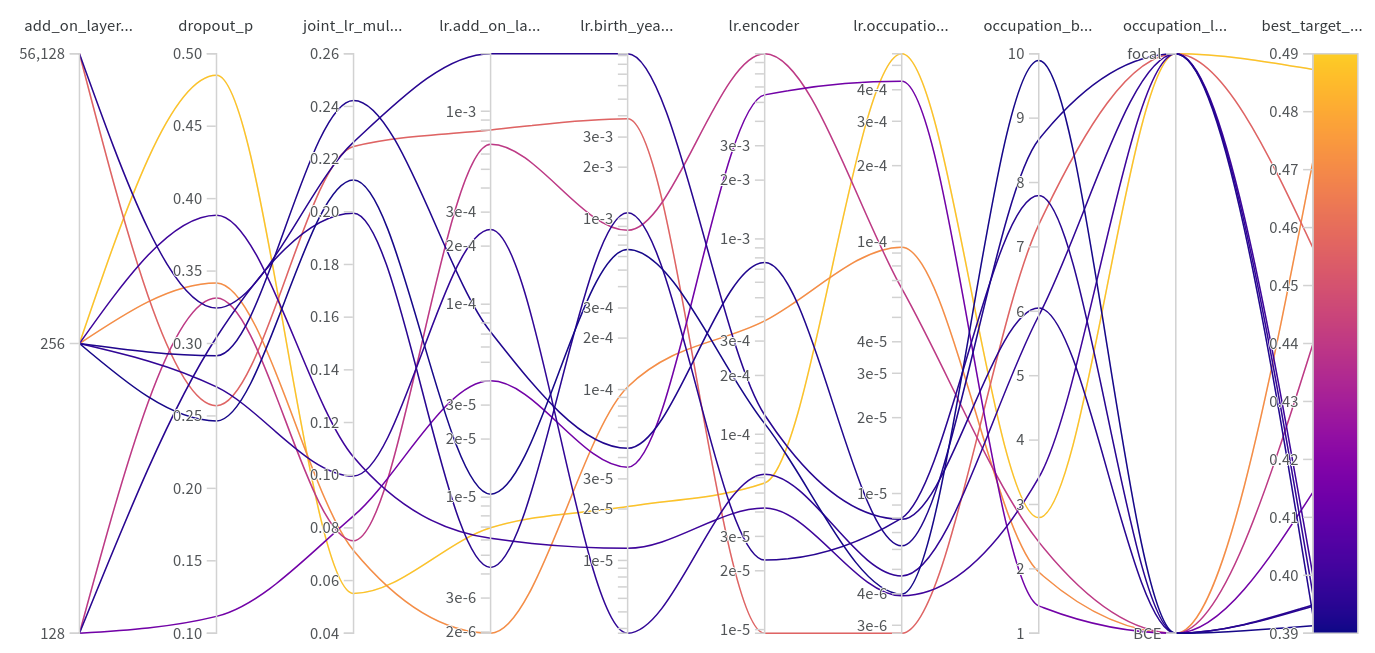

### Model Serving

I used [Gradio](https://www.gradio.app/) to build a shareable model interface. The classification portion required inverting data transformations and presenting the data in a (hopefully) visually appealing way. I hosted the Gradio interface in a [Hugging Face Space](https://huggingface.co/spaces).

I also wanted the model to be useful as a tool for finding relevant quotes. To do this, I first embedded all scraped quotes. Then, I used [FAISS](https://faiss.ai/) to create an efficiently queryable index of the dense embeddings. For any entered quote, the interface retrieves the 100 most similar quotes by dot-product similarity. It then displays the five most similar quotes, filtered by the user's selected "minimum author popularity," as measured by the $\log_2$ of the author's Wikipedia views.